In [1]:
import pickle
import pandas as pd
import os
from utils.plot_decision_trees import plot_tree


from utils.pre_process_data import get_data
from math import ceil
from utils.units import Volume, Dollar
from deap import gp, creator, base, tools
from deap.gp import Terminal
from operator import or_, and_, gt
from fitness_functions import *
from utils.plot_decision_trees import plot_tree
from utils.save_info import save_results
from genetic_functions.cx_functions import cxSubTree
from genetic_functions.mut_functions import mutation_half, mutBranch
from genetic_functions.genetic_program import GPAlgo
import matplotlib.pyplot as plt
import pendulum


In [2]:
df = get_data()
df_train= df.iloc[ : ceil(len(df)*0.7)]
df_test= df.iloc[ceil(len(df)*0.7) : ]

arg_names = list(df_train.columns)
vol_args = [arg for arg in arg_names if "volume" in arg.lower()]
dol_args = [arg for arg in arg_names if "volume" not in arg.lower()]


pset = gp.PrimitiveSetTyped("main",[Volume]*len(vol_args) + [Dollar]*len(dol_args),bool)
        #Rename the arguments:
arg_vol_mapping = {f"ARG{ind}": val for ind,val in enumerate(vol_args)}
pset.renameArguments(**arg_vol_mapping)
arg_dol_mapping = {f"ARG{len(vol_args)+ind}": val for ind,val in enumerate(dol_args)}
pset.renameArguments(**arg_dol_mapping)
#Check that all arguments were renamed:
unnamed_args=[i for i in pset.arguments if "ARG" in i]
if  unnamed_args:
    print(f"Some arguments were not renamed: {unnamed_args}")
pset.addPrimitive(gt, [Dollar,Dollar],bool)
pset.addPrimitive(lambda x:x ,[Dollar],Dollar, name="dollar placeholder")

pset.addPrimitive(gt, [Volume,Volume],bool)
pset.addPrimitive(lambda x:x ,[Volume],Volume, name="volume placeholder")


#Boolean operators:
pset.addPrimitive(and_, [bool,bool],bool)
pset.addPrimitive(or_,[bool,bool],bool)

for v_arg in vol_args:
        pset.addTerminal(v_arg,Volume)
for d_arg in dol_args:
        pset.addTerminal(d_arg,Dollar)

# --- Remove all the ARG terminals ---
pset.terminals[Volume] = [i for i in pset.terminals[Volume] if "ARG" not in i.name]
pset.terminals[Dollar] = [i for i in pset.terminals[Dollar] if "ARG" not in i.name]

def generate(pset):
    run=True
    while run:
        try:
            expr = toolbox.individual()            
            #Remove all the Lambda functions:
            expr=  list(filter(lambda x: x.name!="dollar placeholder", expr))
            expr=  list(filter(lambda x: x.name!="volume placeholder", expr))
            if len(expr)>3:
                run=False
        except IndexError:
            continue
    # return gp.PrimitiveTree(expr)
    return creator.Individual(expr)

# --- GP OPERATORS ----

creator.create("fitness", base.Fitness, weights=(1,))
creator.create("Individual", gp.PrimitiveTree, fitness= creator.fitness)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("custom_individual",generate, pset)
toolbox.register("population", tools.initRepeat, list, toolbox.custom_individual)
toolbox.register("evaluate", fitness_function, df=df_train, pset=pset)

toolbox.register("mate",       cxSubTree)
toolbox.register("select",     tools.selRanked) 
toolbox.register("mutate",     mutation_half, pset=pset)

hof   = tools.HallOfFame(maxsize=50)

#STATS:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0) 
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

/home/khann/masters/utils/pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/home/khann/masters/utils/pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/home/khann/masters/utils/pre_process_data.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

In [3]:
run_list = os.listdir("results_run2")

In [4]:
best_sol_pop = []
for dir in run_list:
    if os.path.isdir(rf"/home/khann/masters/results_run2/{dir}"):
        with open(rf"/home/khann/masters/results_run2/{dir}/hof.pkl", 'rb') as file:
        # Serialize the object and write it to the file
            hof = pickle.load(file)
            best_sol_pop.append(hof[0])
            best_sol_pop.append(hof[1])

In [5]:
[i.fitness.values for i in best_sol_pop]

[(258843.67323373063,),
 (136874.7730249944,),
 (198957.94447866923,),
 (153510.92718828065,),
 (188643.5038174532,),
 (188643.5038174532,),
 (137300.36745099045,),
 (132377.37481674703,),
 (214476.2964305956,),
 (124349.36046711943,),
 (186065.78393546777,),
 (163473.93420371183,),
 (200956.73364127357,),
 (170256.13913920656,),
 (259545.37235238566,),
 (259545.37235238566,),
 (168826.91704740742,),
 (146216.40780361157,),
 (214476.2964305956,),
 (164216.54501489492,),
 (225410.62338176512,),
 (150875.336001747,),
 (157277.49792384927,),
 (135785.97832030413,),
 (214476.2964305956,),
 (131457.424610527,),
 (196891.78076867748,),
 (146946.0977829253,),
 (214476.2964305956,),
 (121027.4116571392,),
 (139196.69620355094,),
 (136769.25849888113,),
 (214476.2964305956,),
 (138846.4115819129,),
 (157081.6804641192,),
 (131401.46048534702,),
 (140630.1575459576,),
 (127854.35076672035,),
 (218738.10696443333,),
 (129555.24211389845,),
 (170256.13913920656,),
 (151551.86929682773,),
 (186180.

In [6]:
best_sol_pop

[[<deap.gp.Primitive at 0x7f9c916a1e40>,

In [7]:
cnt=0
for dir in run_list:
    if os.path.isdir(rf"/home/khann/masters/results_run2/{dir}"):
        if cnt == 0:
            df_tmp = pd.read_csv(rf"/home/khann/masters/results_run2/{dir}/run_info.csv")
            df_tmp.drop('Unnamed: 0',axis=1, inplace=True)
        else:
            d = pd.read_csv(rf"/home/khann/masters/results_run2/{dir}/run_info.csv")
            d.drop('Unnamed: 0',axis=1, inplace=True)
            df_tmp = pd.concat([df_tmp, d], ignore_index=True, sort=False)
        cnt+=1


<Axes: >

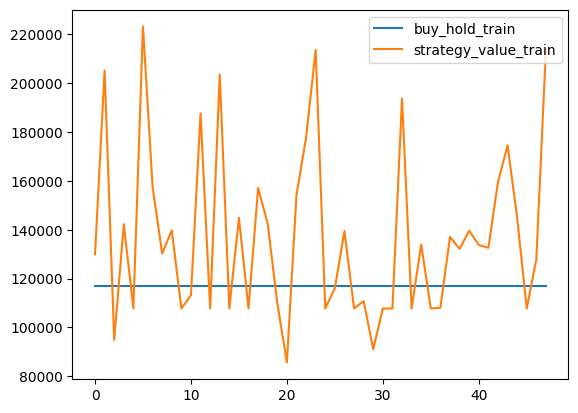

In [8]:
df_tmp[['buy_hold_train', 'strategy_value_train']].plot()

In [9]:
# res = pd.read_csv(r"/home/khann/masters/results/run_2024-08-03_08-38/run_info.csv")
# res.columns

In [23]:
best_sol_pop.sort(key = lambda x : x.fitness.values, reverse=True)

In [11]:
# plot_tree(best_sol_pop[0] , name="tree_gen1_best_sol")

In [12]:
per_list = []
for k in best_sol_pop:
    per = [i.split("_")[-1] for i in str(k).split("'") if "percentage" in i]
    if per:
        per_list.append(per)
print(per_list)

[['57'], ['57'], ['57'], ['57'], ['37'], ['57'], ['57'], ['57'], ['57'], ['37'], ['57'], ['57'], ['37'], ['57'], ['57'], ['57'], ['37'], ['37'], ['57'], ['37'], ['37'], ['57'], ['57'], ['37'], ['57'], ['57'], ['57'], ['57'], ['37'], ['37'], ['37'], ['57'], ['57'], ['57'], ['37'], ['37'], ['37'], ['57'], ['57'], ['37'], ['37'], ['37'], ['37'], ['57'], ['37'], ['37'], ['57'], ['57'], ['57'], ['57'], ['57'], ['37'], ['37', '37'], ['57'], ['57'], ['57']]


In [13]:

# with open(rf"/home/khann/masters/results/run2_2024-08-09_09-20/logbook.pkl", 'rb') as file:
# # Serialize the object and write it to the file
#     logbook = pickle.load(file)

# with open(rf"/home/khann/masters/results/run2_2024-08-09_09-20/hof.pkl", 'rb') as file:
# # Serialize the object and write it to the file
#     hof2 = pickle.load(file)

In [15]:
# max_lst = []
# for i in logbook:
#     max_lst.append(i['max'])
# x=range(0,len(max_lst))

In [27]:
lst_bsp_test = []
for i in best_sol_pop:
    lst_bsp_test.append(trading_strat(individual = i, df=df_test,pset=pset)[:2])

In [34]:
lst_bsp_train = []
for i in best_sol_pop:
    lst_bsp_train.append(trading_strat(individual = i, df=df_train ,pset=pset)[:2])

Text(0.5, 1.0, 'Fitness values of the strategies.')

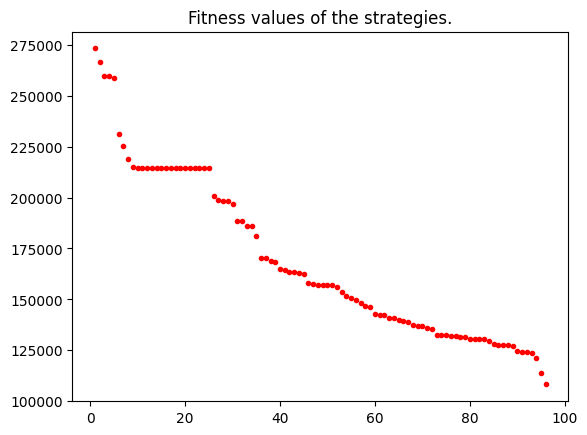

In [24]:
plt.plot(range(1,len(best_sol_pop)+1),[i.fitness.values for i in best_sol_pop],'r.')
plt.title("Fitness values of the strategies.")

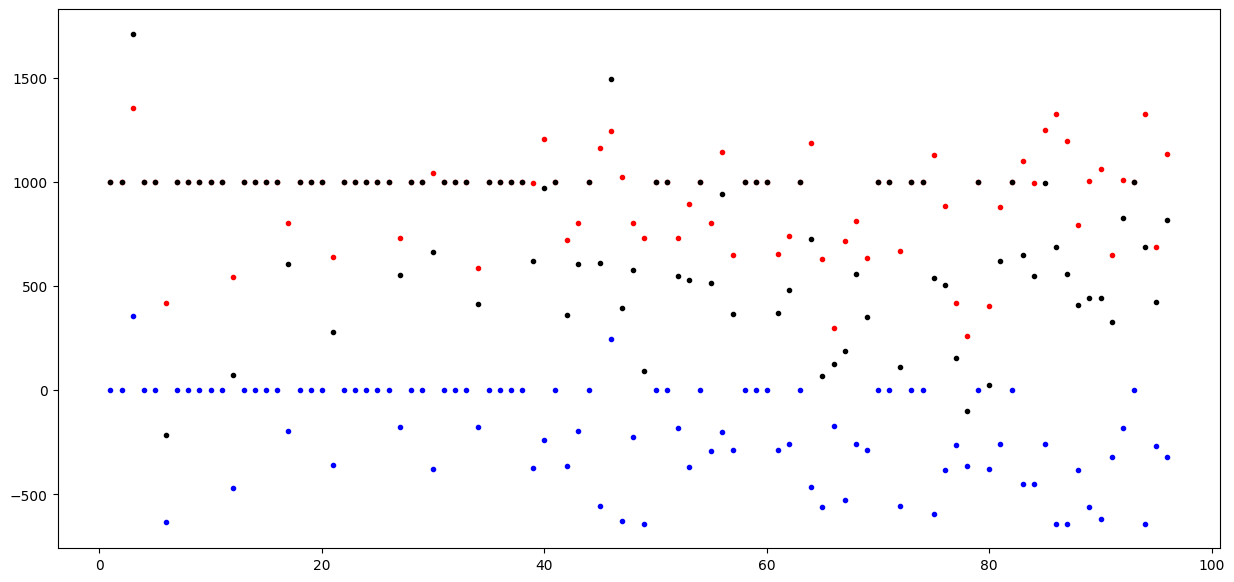

In [28]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(best_sol_pop)+1),[i[0] for i in lst_bsp_test],'r.')
plt.plot(range(1,len(best_sol_pop)+1),[i[1] for i in lst_bsp_test],'b.')
plt.plot(range(1,len(best_sol_pop)+1),[i[0]+i[1]  for i in lst_bsp_test],'k.')

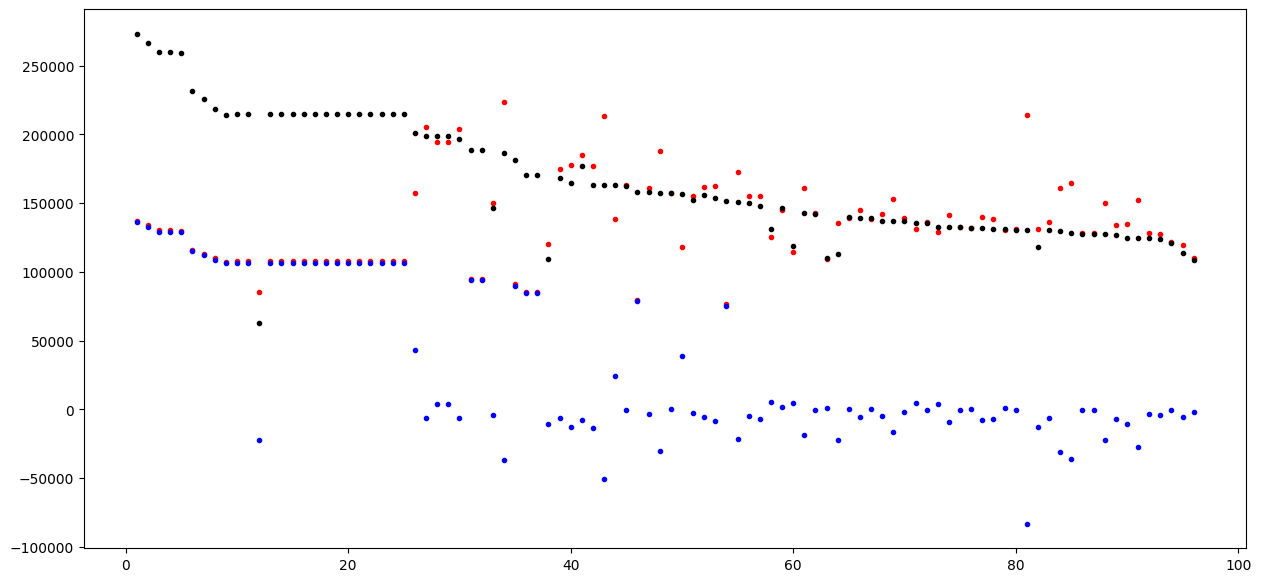

In [35]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(best_sol_pop)+1),[i[0] for i in lst_bsp_train],'r.')
plt.plot(range(1,len(best_sol_pop)+1),[i[1] for i in lst_bsp_train],'b.')
plt.plot(range(1,len(best_sol_pop)+1),[i[0]+i[1]  for i in lst_bsp_train],'k.')

In [33]:
str([i for i in best_sol_pop if i.fitness.values == (214476.2964305956,)][0])

"or_(or_(and_(gt('lag_volume_38', 'ma_volume_49'), gt('lag_volume_19', 'ma_volume_47')), gt('ma_volume_48', 'lag_volume_9')), gt('ma_volume_15', 'percentage_volume_37'))"

In [ ]:
max([i.fitness.values for i in best_sol_pop])

In [39]:
print(best_sol_pop[2])

or_(or_(gt('lag_volume_19', 'lag_volume_21'), gt('ma_close_39', 'ma_open_16')), or_(or_(gt('ma_volume_42', 'lag_volume_32'), or_(gt('ma_volume_45', 'ma_volume_8'), gt('lag_volume_9', 'lag_volume_23'))), gt('ma_high_27', 'ma_high_42')))


In [38]:
best_solution = best_sol_pop[2]
tc = 0.01
print("TRAIN")
print("Buy and hold:",(1000/df_test.iloc[0]['Open'])*df_test.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(df_test))
print("strat value :",trading_strat(individual = best_solution, df=df_test,pset=pset)[0],'\n')

TRAIN
Buy and hold: 1163.7100970760914
mtv         : 177218.81839494675
strat value : 1356.3500034530482 



In [ ]:
lst = []
for i in best_sol_pop:
    lst.append(trading_strat(individual = i, df=df_test,pset=pset)[0])

In [ ]:
max(lst)

In [ ]:
lst_hof_test = []
for i in hof2:
    lst_hof_test.append(trading_strat(individual = i, df=df_test,pset=pset)[:2])

lst_hof_train = []
for i in hof2:
    lst_hof_train.append(trading_strat(individual = i, df=df_train ,pset=pset)[:2])

In [ ]:
[i for i in lst if i>1163]

In [ ]:
print("Buy and hold:",(1000/df_train.iloc[0]['Open'])*df_train.iloc[-1]['Open']*(1-tc)**2)


In [ ]:
plt.plot(range(1,len(hof2)+1),[i.fitness.values for i in hof2],'r.')
plt.title("Fitness values of the strategies.")


In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof2)+1),[i[0] for i in lst_hof_test],'r.')
plt.plot(range(1,len(hof2)+1),[i[1] for i in lst_hof_test],'b.')
plt.plot(range(1,len(hof2)+1),[i[0]+i[1]  for i in lst_hof_test],'k.')


plt.title("test data")

In [ ]:
[i[0]+i[1]  for i in lst_hof_test]

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof2)+1),[i[0] for i in lst_hof_train],'r.')
plt.plot(range(1,len(hof2)+1),[i[1] for i in lst_hof_train],'b.')
plt.plot(range(1,len(hof2)+1),[i[0]-i[1] for i in lst_hof_train],'k.')


plt.title("train data")
print([i[0]-i[1] for i in lst_hof_train])

In [ ]:
with open(rf"/home/khann/masters/results_run2/run_2024-08-10_02-20/hof.pkl", 'rb') as file:
        # Serialize the object and write it to the file
            hof = pickle.load(file)

In [ ]:
lst_hof_test = []
for i in hof.items:
    lst_hof_test.append(trading_strat(individual = i, df=df_test,pset=pset)[:2])

lst_hof_train = []
for i in hof.items:
    lst_hof_train.append(trading_strat(individual = i, df=df_train,pset=pset)[:2])

In [ ]:
lst_hof_test

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof)+1),[i[0] for i in lst_hof_test],'r.')
plt.plot(range(1,len(hof)+1),[i[1] for i in lst_hof_test],'b.')
plt.plot(range(1,len(hof)+1),[i[0]+i[1]  for i in lst_hof_test],'k.')

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof)+1),[i[0] for i in lst_hof_train],'r.')
plt.plot(range(1,len(hof)+1),[i[1] for i in lst_hof_train],'b.')
plt.plot(range(1,len(hof)+1),[i[0]+i[1]  for i in lst_hof_train],'k.')

In [ ]:
[i.fitness.values for i in hof.items]